# Chapter 6 — LangGraph Basics I: Reasoning as a Graph

**Colab Teaching Notebook (Sections 6.1–6.9)**

Run cells top-to-bottom once to load helpers, simulation code, and visuals.

## 0. Setup & Helpers

In [1]:

import time, random
from dataclasses import dataclass, field
from typing import Any, Dict, List, Callable, Tuple

# Optional libs (kept standard so it runs in vanilla Colab)
try:
    import matplotlib.pyplot as plt
    HAS_MPL = True
except Exception:
    HAS_MPL = False

try:
    import networkx as nx
    HAS_NX = True
except Exception:
    HAS_NX = False

def ensure_plot():
    if not HAS_MPL:
        raise RuntimeError("Matplotlib is not available in this environment.")

def ensure_graph():
    if not HAS_NX:
        raise RuntimeError("networkx is not available in this environment.")

print(f"Matplotlib: {'✓' if HAS_MPL else '×'} | networkx: {'✓' if HAS_NX else '×'}")


Matplotlib: ✓ | networkx: ✓


## 6.1 Concept Flow — From Chains to Graphs
**Teaching goal:** Understand why we branch, re-query, and run steps in parallel.

- **Chain**: fixed order.
- **Graph**: nodes (retriever, analyzer, LLM, verifier) + edges (data flow / decisions).
- Branch rule example: *if confidence < τ → re-query*.

In [2]:

# Minimal chain vs graph simulation
def mock_retriever(q: str) -> Dict[str, Any]:
    # retrieval quality increases with query length (toy)
    quality = min(1.0, 0.4 + len(q) * 0.03)
    return {"context": f"CTX({q})", "quality": quality}

def mock_analyzer(ctx: Dict[str, Any], tau: float=0.7) -> Dict[str, Any]:
    confidence = 0.5*ctx["quality"] + 0.25 + random.uniform(-0.05, 0.05)
    decision = "requery" if confidence < tau else "proceed"
    return {"confidence": round(confidence, 3), "decision": decision}

def mock_llm(ctx: Dict[str, Any], confidence: float) -> str:
    return f"Answer[{ctx['context']}] :: conf={confidence:.2f}"

def run_chain(q: str):
    ctx = mock_retriever(q)
    return {"mode":"chain", "answer": mock_llm(ctx, 1.0), "ctx": ctx}

def run_graph(q: str, tau: float=0.7, max_loops:int=3):
    loops = 0
    ctx = mock_retriever(q)
    while loops < max_loops:
        loops += 1
        check = mock_analyzer(ctx, tau=tau)
        if check["decision"] == "proceed":
            return {"mode":"graph", "loops": loops, "ctx":ctx, "check":check,
                    "answer": mock_llm(ctx, check["confidence"])}
        # branch back to retrieval (ask for a bit more context)
        ctx = mock_retriever(q + " +")
    return {"mode":"graph", "loops": loops, "ctx":ctx, "check":check,
            "answer": mock_llm(ctx, check["confidence"]), "note":"hit loop cap"}

print(run_chain("quantum attention"))
print(run_graph("quantum attention"))


{'mode': 'chain', 'answer': 'Answer[CTX(quantum attention)] :: conf=1.00', 'ctx': {'context': 'CTX(quantum attention)', 'quality': 0.91}}
{'mode': 'graph', 'loops': 2, 'ctx': {'context': 'CTX(quantum attention +)', 'quality': 0.97}, 'check': {'confidence': 0.774, 'decision': 'proceed'}, 'answer': 'Answer[CTX(quantum attention +)] :: conf=0.77'}


### Graph sketch (Retriever → Analyzer → LLM with re-query branch)

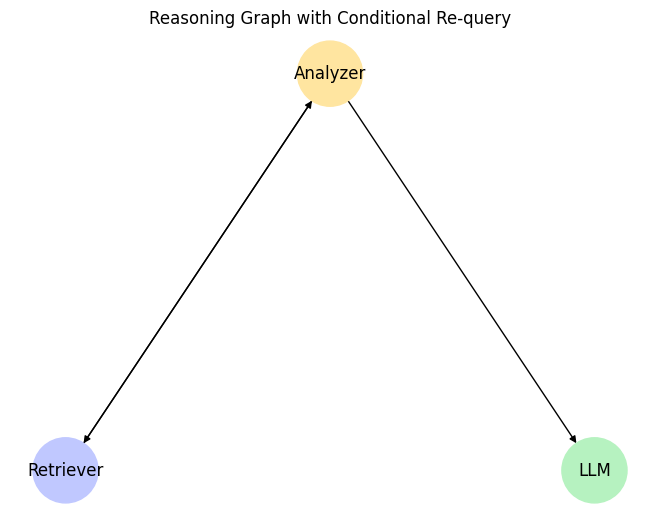

In [3]:

ensure_graph(); ensure_plot()
G = nx.DiGraph()
G.add_edges_from([("Retriever","Analyzer"),("Analyzer","LLM"),("Analyzer","Retriever")])
pos = {"Retriever":(0,0),"Analyzer":(1,0.5),"LLM":(2,0)}
nx.draw(G, pos, with_labels=True, node_color=["#c0c8ff","#ffe5a0","#b6f2c0"], node_size=2200, arrows=True)
plt.title("Reasoning Graph with Conditional Re-query")
plt.show()


## 6.2 Math / CS Mini — Formalism Behind LangGraph
**DAG** $G=(V,E)$; each node $v_i$ computes $y_i=f_i(x_i, s_i)$; execute in **topological order**.

**Parallelism**
- Sequential cost (one pass): $T_{seq} \propto |V|+|E|$.
- If a layer has width $k$, ideal time: $T_{par} = T_{seq}/k$.

In [4]:

# Compute topological layers and ideal parallel time for a toy DAG
ensure_graph()
def topo_layers(edges, nodes):
    G = nx.DiGraph(); G.add_nodes_from(nodes); G.add_edges_from(edges)
    layers, remaining = [], set(G.nodes())
    indeg = {n:G.in_degree(n) for n in G.nodes()}
    while remaining:
        L = [n for n in remaining if indeg[n]==0]
        if not L: raise ValueError("Cycle detected.")
        layers.append(L)
        for n in L:
            remaining.remove(n)
            for succ in G.successors(n):
                indeg[succ]-=1
    return layers

nodes = ["A","B","C","D","E"]
edges = [("A","B"),("A","C"),("B","D"),("C","E")]
layers = topo_layers(edges, nodes)
T_seq = len(nodes)               # unit work per node
k = max(len(L) for L in layers)  # widest parallel layer
T_par = T_seq / k
layers, T_seq, k, T_par


([['A'], ['B', 'C'], ['D', 'E']], 5, 2, 2.5)

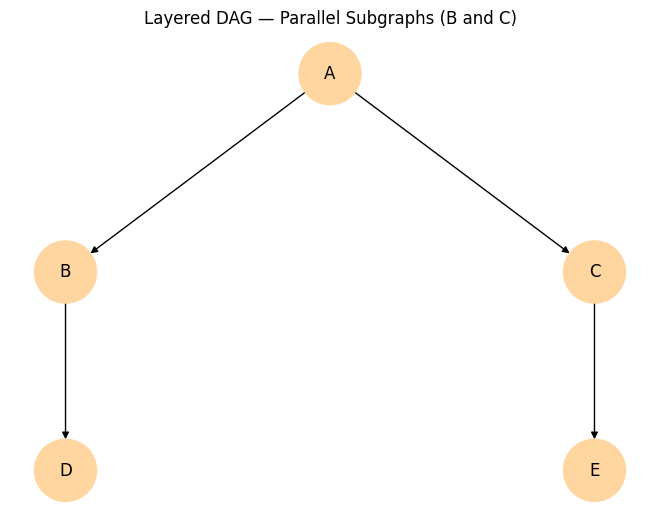

In [5]:

# Visualize layered DAG
ensure_plot(); ensure_graph()
G = nx.DiGraph(); G.add_edges_from([("A","B"),("A","C"),("B","D"),("C","E")])
pos = {"A":(0,2), "B":(-1,1), "C":(1,1), "D":(-1,0), "E":(1,0)}
nx.draw(G, pos, with_labels=True, node_color=["#ffd6a0"]*5, node_size=2000, arrows=True)
plt.title("Layered DAG — Parallel Subgraphs (B and C)")
plt.show()


## 6.3 Satyam’s Explanation — *Cake with Friends*
People = nodes; “can’t start before” = edges; optional taste-test loop = conditional branch.
Parallel steps (mix vs. preheat) speed up; verification prevents serving a bad cake.

## 6.4 Workflow / Demos — Build Your First Reasoning Graph
We’ll create a tiny runtime that carries a **shared state dict** and routes by a **policy** (confidence ≥ τ).

In [6]:

from dataclasses import dataclass, field

@dataclass
class Node:
    name: str
    fn: Callable[[Dict[str, Any]], Dict[str, Any]]

@dataclass
class ReasoningGraph:
    edges: List[Tuple[str,str]]
    nodes: Dict[str, Node]
    start: str
    policy: Callable[[Dict[str, Any]], str]
    state: Dict[str, Any] = field(default_factory=dict)
    trace: List[Tuple[str, Dict[str, Any]]] = field(default_factory=list)

    def run(self, max_steps=20):
        current = self.start
        for _ in range(max_steps):
            out = self.nodes[current].fn(self.state)
            self.state.update(out)
            self.trace.append((current, out))
            nxt = self.policy({**self.state, "last": current})
            if nxt == "__END__": break
            current = nxt
        return self.state, self.trace

def n_retriever(state):
    q = state.get("query","")
    hops = state.get("hops", 0)
    ctx_quality = min(1.0, 0.5 + 0.15*hops + 0.02*len(q))
    return {"context": f"CTX_{hops}({q})", "ctx_quality": round(ctx_quality,3), "hops": hops+1}

def n_analyzer(state):
    conf = 0.6 * state["ctx_quality"] + 0.2 + random.uniform(-0.03,0.03)
    return {"confidence": round(conf,3)}

def n_llm(state):
    return {"answer": f"Final[{state['context']}|conf={state['confidence']:.2f}]"}

def policy(state, tau=0.7):
    last = state["last"]
    if last == "retriever": return "analyzer"
    if last == "analyzer":  return "llm" if state["confidence"] >= tau else "retriever"
    if last == "llm":       return "__END__"
    return "__END__"

graph = ReasoningGraph(
    edges=[("retriever","analyzer"),("analyzer","llm"),("analyzer","retriever")],
    nodes={"retriever": Node("retriever", n_retriever),
           "analyzer":  Node("analyzer",  n_analyzer),
           "llm":       Node("llm",       n_llm)},
    start="retriever",
    policy=policy,
    state={"query":"latest research on quantum attention"}
)

final_state, trace = graph.run()
final_state, trace


({'query': 'latest research on quantum attention',
  'context': 'CTX_0(latest research on quantum attention)',
  'ctx_quality': 1.0,
  'hops': 1,
  'confidence': 0.806,
  'answer': 'Final[CTX_0(latest research on quantum attention)|conf=0.81]'},
 [('retriever',
   {'context': 'CTX_0(latest research on quantum attention)',
    'ctx_quality': 1.0,
    'hops': 1}),
  ('analyzer', {'confidence': 0.806}),
  ('llm',
   {'answer': 'Final[CTX_0(latest research on quantum attention)|conf=0.81]'})])

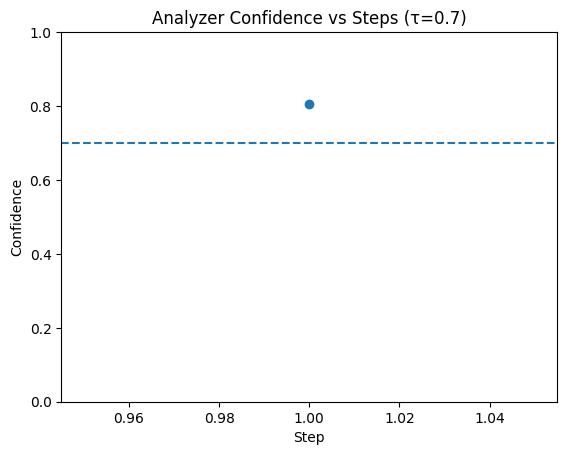

In [7]:

# Confidence trace
ensure_plot()
conf = [t[1].get("confidence", float('nan')) for t in trace]
plt.plot(conf, marker='o'); plt.axhline(0.7, ls='--'); plt.ylim(0,1)
plt.title("Analyzer Confidence vs Steps (τ=0.7)")
plt.xlabel("Step"); plt.ylabel("Confidence")
plt.show()


## 6.5 Comparison — Chains vs Graphs
| Aspect | Chains | Graphs |
|---|---|---|
| Structure | Linear sequence | Directed acyclic graph |
| Execution | Fixed order | Conditional / dynamic |
| Parallelism | Sequential | Independent layers run in parallel |
| State | Implicit | Shared state dictionary |
| Error Recovery | Global retry | Node-level reroute/retry |
| Best Use | Simple demos | Complex, explainable orchestration |

## 6.6 Exercises (Auto-check)
1) **Topological Order** — verify DAG and list one valid order.
2) **Speedup** — compute ideal speedup for given layer widths.

In [8]:

# 1) DAG check
def is_dag(edges, nodes):
    ensure_graph()
    G = nx.DiGraph(); G.add_nodes_from(nodes); G.add_edges_from(edges)
    return nx.is_directed_acyclic_graph(G), list(nx.topological_sort(G))

nodes_ex = ["A","B","C","D"]
edges_ex = [("A","B"),("A","C"),("B","D"),("C","D")]
is_dag(edges_ex, nodes_ex)


(True, ['A', 'B', 'C', 'D'])

In [9]:

# 2) Ideal speedup
def ideal_speedup(layer_widths):
    T_seq = sum(layer_widths)  # unit work / node
    T_par = len(layer_widths)  # unit work / layer
    return {"T_seq":T_seq, "T_par":T_par, "speedup":T_seq/T_par}

ideal_speedup([1,2,2])


{'T_seq': 5, 'T_par': 3, 'speedup': 1.6666666666666667}

## 6.8 Industry Skill Tie-In — Metrics that Matter
- **Parallel gain** $G_p = T_{seq}/T_{par}$
- **Branch ratio** = activated branches / total node executions
- **Failure isolation** (not simulated here) = recoverable / total failures

In [10]:

# Branch ratio from the earlier graph run
total_nodes = len(trace)
activated_branches = sum(1 for i in range(1,len(trace))
                         if trace[i-1][0]=="analyzer" and trace[i][0]=="retriever")
branch_ratio = activated_branches / max(1,total_nodes)

# Toy parallel gain using layered DAG earlier (A→{B,C}→{D,E}), k=2 layer width
Gp = 5 / (5/2)

{"branch_ratio": round(branch_ratio,3), "parallel_gain": round(Gp,3)}


{'branch_ratio': 0.0, 'parallel_gain': 2.0}

## 6.9 Closing Visual — The Reasoning Graph Stack

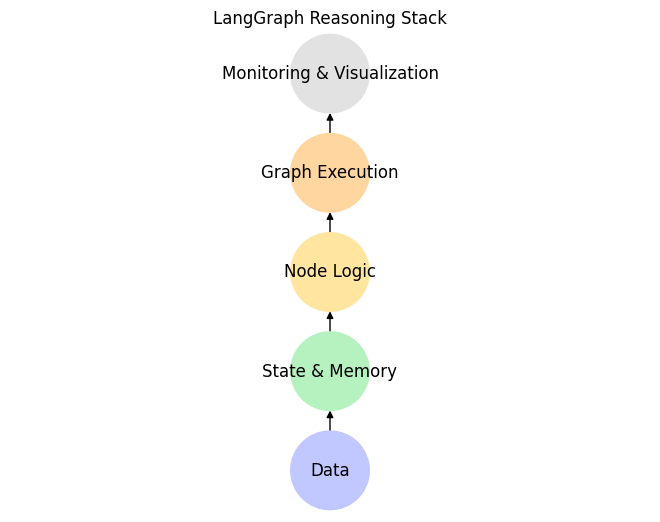

In [11]:

ensure_plot(); ensure_graph()
layers = [("Data","State & Memory"),
          ("State & Memory","Node Logic"),
          ("Node Logic","Graph Execution"),
          ("Graph Execution","Monitoring & Visualization")]
G = nx.DiGraph(); G.add_edges_from(layers)
pos = {"Data":(0,0),"State & Memory":(0,1),"Node Logic":(0,2),
       "Graph Execution":(0,3),"Monitoring & Visualization":(0,4)}
colors = ["#c0c8ff","#b6f2c0","#ffe5a0","#ffd6a0","#e2e2e2"]
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=3200, arrows=True)
plt.title("LangGraph Reasoning Stack")
plt.show()
